# Import Library

In [1]:
import pandas as pd 
import numpy as np 
import ast
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, median_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# Load dataset
df = pd.read_csv('Chem Trend.csv')
df.head()

,ID CT,FUNCTION,MATERIAL,DAY_RUN,RR,NAOCL,AVG_T_RETURN,CONDUCT LIMIT,AVG_FRC,AVG_CHLORIDE,TOTAL BACTERIA,BACTERIA_STATUS
0,Cooling Tower Ref A,PROCESS,Stainless steel,30,400,297.69,32.1,1200,0.21,158.07,1000,Acceptable
1,Cooling Tower Fract B,FRACTIONATION,"Stainless steel, Cuprum, Galvanized",30,2400,1997.31,35.4,1500,0.19,293.87,1000,Acceptable
2,Cooling Tower Ref C,PROCESS,Stainless steel,30,450,716.54,39.3,1200,0.19,185.07,1000,Acceptable
3,Cooling Tower Fract D,FRACTIONATION,"Stainless steel, Cuprum, Galvanized",30,700,1076.54,31.8,700,0.26,127.24,1000,Acceptable
4,Cooling Tower Refra E,FRACTIONATION,"Stainless steel, Cuprum, Galvanized",30,2496,1041.92,32.6,1500,0.14,240.24,10000,Acceptable


Keterangan Feature:

Detail feature:
- ID CT = Identitas Cooling Tower
- FUNCTION = Tipe proses yang didinginkan oleh cooling tower
- MATERIAL = Material pipa yang dilewati oleh cooling water
- DAY_RUN = Hari digunakannya cooling tower
- NAOCL = Jumlah NAOCL dalam kg yang dibutuhkan dalam 1 bulan
- CONDUCT_LIMIT = Limit conductivity terhadap design cooling tower
- AVG FRC = rerata konsentrasi Free Residual Chlorine (ppm)
- AVG CHLORIDE = rerata konsentrasi chloride (ppm)
- TOTAL BACTERIA = Total bakteri dalam cooling tower 
- RR = Recirculating Rate Cooling Tower (m3/h)
- BACTERIA_STATUS= Kondisi ditoleransi/tidaknya jumlah bakteri yang ada pda cooling tower

Informasi tambahan:
- AVG FRC ideal adalah 0.2-0.5


Bebebrapa feature yang bisa dikombinasi:
- Material X AVG Chloride
- AVG_FRC X Total bacteria
- AVG FRC X Bacteria status
- RR X AVG_FRC = untuk melihat apakah semakin besar RR menunjukkan kecenderungan semakin sulit menjaga nilai VG FRC

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID CT            220 non-null    object 
 1   FUNCTION         220 non-null    object 
 2   MATERIAL         220 non-null    object 
 3   DAY_RUN          220 non-null    int64  
 4   RR               220 non-null    int64  
 5   NAOCL            220 non-null    float64
 6   AVG_T_RETURN     220 non-null    float64
 7   CONDUCT LIMIT    220 non-null    int64  
 8   AVG_FRC          220 non-null    float64
 9   AVG_CHLORIDE     220 non-null    float64
 10  TOTAL BACTERIA   220 non-null    int64  
 11  BACTERIA_STATUS  220 non-null    object 
dtypes: float64(4), int64(4), object(4)
memory usage: 20.8+ KB


In [4]:
df.describe()

,DAY_RUN,RR,NAOCL,AVG_T_RETURN,CONDUCT LIMIT,AVG_FRC,AVG_CHLORIDE,TOTAL BACTERIA
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,27.900000,1319.272727,796.932109,36.054545,1172.727273,0.320136,167.074068,28404.545455
std,5.391436,849.473121,496.167222,4.090163,317.210758,0.212142,123.924778,75349.080933
min,0.000000,350.000000,0.000000,31.800000,700.000000,0.000000,39.750000,0.000000
25%,28.000000,450.000000,433.920000,32.100000,700.000000,0.190000,120.670000,1000.000000
50%,30.000000,1092.000000,711.710000,35.400000,1200.000000,0.260000,155.720000,10000.000000
75%,31.000000,2400.000000,1050.045000,39.300000,1500.000000,0.380000,187.317500,10000.000000
max,31.000000,2500.000000,3080.800000,45.400000,1500.000000,1.310000,1800.360000,1000000.000000


In [5]:
data_unvalid = df.loc[df['DAY_RUN']==0]
data_unvalid

,ID CT,FUNCTION,MATERIAL,DAY_RUN,RR,NAOCL,AVG_T_RETURN,CONDUCT LIMIT,AVG_FRC,AVG_CHLORIDE,TOTAL BACTERIA,BACTERIA_STATUS
55,Cooling Tower Ref A,PROCESS,Stainless steel,0,400,0.0,32.1,1200,0.0,128.68,0,Acceptable


data pada index 55 tdk valid

In [6]:
df = df.drop(index=55, axis=0)

In [7]:
df.isnull().sum()

ID CT              0
FUNCTION           0
MATERIAL           0
DAY_RUN            0
RR                 0
NAOCL              0
AVG_T_RETURN       0
CONDUCT LIMIT      0
AVG_FRC            0
AVG_CHLORIDE       0
TOTAL BACTERIA     0
BACTERIA_STATUS    0
dtype: int64

In [8]:
df['MATERIAL'].value_counts()

MATERIAL
Stainless steel                        99
Stainless steel, Cuprum, Galvanized    80
Stainless steel, Galvanized            40
Name: count, dtype: int64

In [9]:
df['DAY_RUN'].value_counts()

DAY_RUN
30    77
31    71
29    14
28    12
22     8
24     6
18     5
20     4
8      4
25     4
27     3
26     2
12     2
15     1
14     1
19     1
16     1
13     1
6      1
23     1
Name: count, dtype: int64

In [10]:
df['TOTAL BACTERIA'].value_counts()

TOTAL BACTERIA
10000      108
1000        69
100000      41
1000000      1
Name: count, dtype: int64

In [11]:
df['BACTERIA_STATUS'].value_counts()

BACTERIA_STATUS
Acceptable        177
Not Acceptable     42
Name: count, dtype: int64

In [12]:
df['ID CT'].value_counts()

ID CT
Cooling Tower Fract B    20
Cooling Tower Ref C      20
Cooling Tower Fract D    20
Cooling Tower Ref H      20
Cooling Tower Refra E    20
Cooling Tower Ref F      20
Cooling Tower Fract G    20
Cooling Tower Fract J    20
Cooling Tower Fract I    20
Cooling Tower Ref K      20
Cooling Tower Ref A      19
Name: count, dtype: int64

In [13]:
df['CONDUCT LIMIT'].value_counts()

CONDUCT LIMIT
1500    80
1200    79
700     60
Name: count, dtype: int64

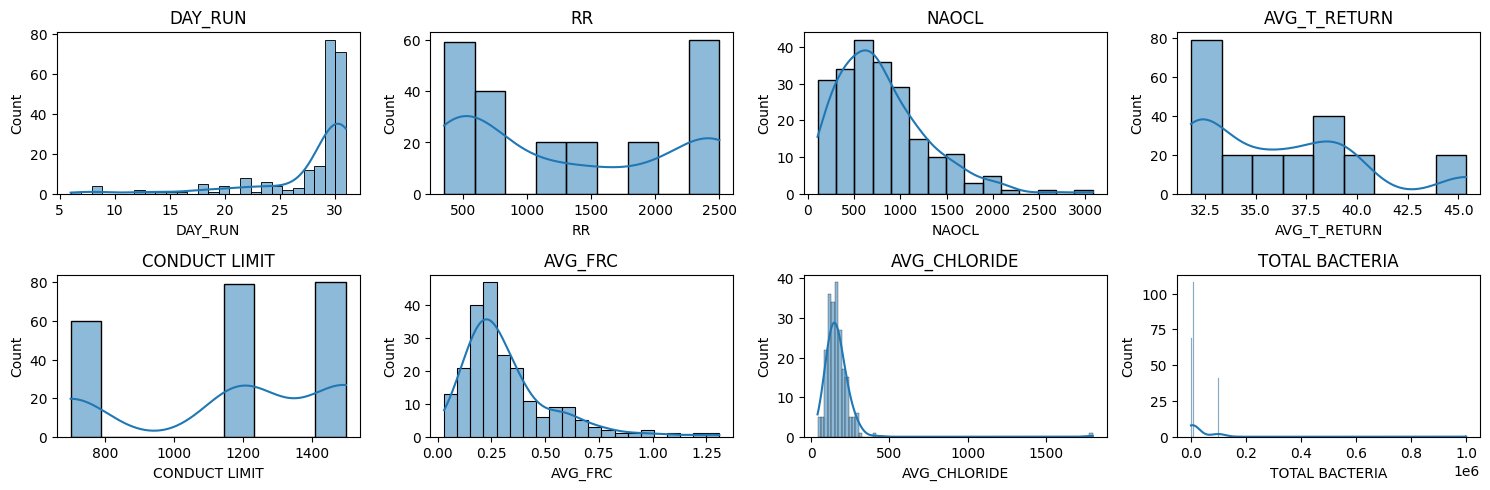

In [14]:
numeric_cols= df.select_dtypes(include='number').columns

plt.figure(figsize=(15,7))

for i, col in enumerate(numeric_cols):
    plt.subplot(3, 4, i + 1) 
    sns.histplot(df[col], kde=True)  
    plt.title(col)  

plt.tight_layout()  
plt.show()

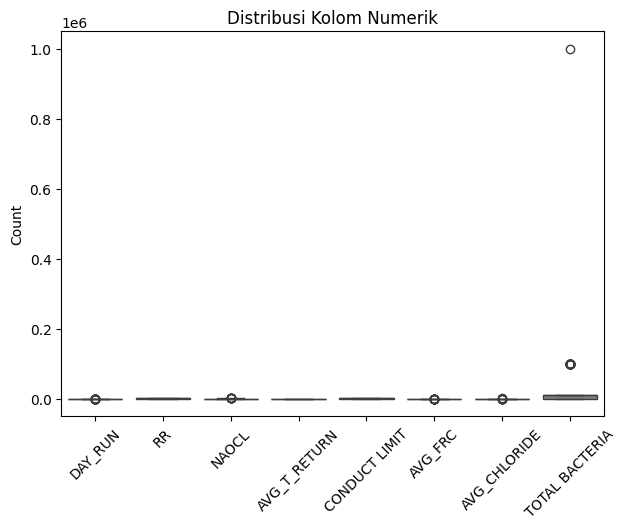

In [15]:
plt.figure(figsize=(7,5))
sns.boxplot(df[numeric_cols])
plt.title('Distribusi Kolom Numerik')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

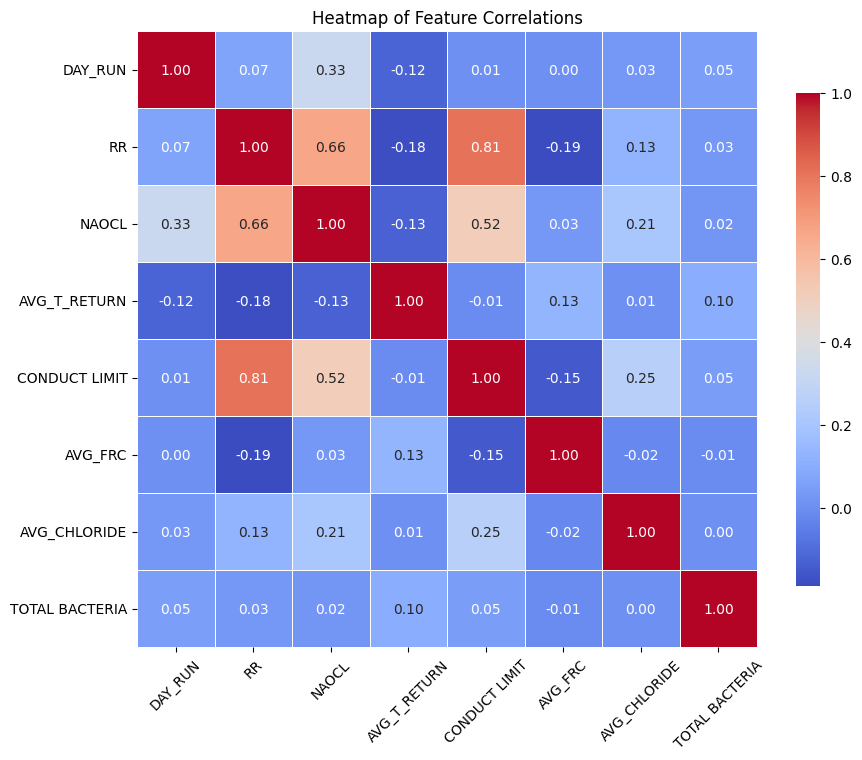

In [16]:
corr = df[numeric_cols].corr()
# Membuat heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Heatmap of Feature Correlations')
plt.xticks(rotation=45)
plt.show()

In [17]:
nan_column = ['AVG_FRC', 'TOTAL BACTERIA']
cat_column = [col for col in df.columns if df[col].dtype == 'object']
num_column = [col for col in df.columns if col not in cat_column and col != 'NAOCL']

# Data Cleaning

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, 0 to 219
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID CT            219 non-null    object 
 1   FUNCTION         219 non-null    object 
 2   MATERIAL         219 non-null    object 
 3   DAY_RUN          219 non-null    int64  
 4   RR               219 non-null    int64  
 5   NAOCL            219 non-null    float64
 6   AVG_T_RETURN     219 non-null    float64
 7   CONDUCT LIMIT    219 non-null    int64  
 8   AVG_FRC          219 non-null    float64
 9   AVG_CHLORIDE     219 non-null    float64
 10  TOTAL BACTERIA   219 non-null    int64  
 11  BACTERIA_STATUS  219 non-null    object 
dtypes: float64(4), int64(4), object(4)
memory usage: 22.2+ KB


In [19]:
# Pecah MATERIAL menjadi list menggunakan koma sebagai pemisah
df['MATERIAL'] = df['MATERIAL'].apply(lambda x: x.split(', '))

# Menggunakan MultiLabelBinarizer untuk multi-hot encoding
mlb = MultiLabelBinarizer()
material_encoded = mlb.fit_transform(df['MATERIAL'])

# Konversi hasil menjadi DataFrame dengan nama kolom dari bahan unik
material_df = pd.DataFrame(material_encoded, columns=mlb.classes_)
material_df

,Cuprum,Galvanized,Stainless steel
0,0,0,1
1,1,1,1
2,0,0,1
3,1,1,1
4,1,1,1
...,...,...,...
214,1,1,1
215,0,0,1
216,0,1,1
217,0,1,1


In [20]:
# merge materian encoded dengan df
df_encoded = pd.concat([df, material_df], axis=1)

In [21]:
# function for categorize Conduct limit
def categorize_conduct(value):
    if value <= 700:
        return 1
    elif value <= 1200:
        return 2
    else:
        return 3

# Apply fungsi ke kolom 'CONDUCT LIMIT'
df_encoded['conduct_category'] = df_encoded['CONDUCT LIMIT'].apply(categorize_conduct)
    

In [22]:
df_encoded.head()

,ID CT,FUNCTION,MATERIAL,DAY_RUN,RR,NAOCL,AVG_T_RETURN,CONDUCT LIMIT,AVG_FRC,AVG_CHLORIDE,TOTAL BACTERIA,BACTERIA_STATUS,Cuprum,Galvanized,Stainless steel,conduct_category
0,Cooling Tower Ref A,PROCESS,[Stainless steel],30.0,400.0,297.69,32.1,1200.0,0.21,158.07,1000.0,Acceptable,0.0,0.0,1.0,2
1,Cooling Tower Fract B,FRACTIONATION,"[Stainless steel, Cuprum, Galvanized]",30.0,2400.0,1997.31,35.4,1500.0,0.19,293.87,1000.0,Acceptable,1.0,1.0,1.0,3
2,Cooling Tower Ref C,PROCESS,[Stainless steel],30.0,450.0,716.54,39.3,1200.0,0.19,185.07,1000.0,Acceptable,0.0,0.0,1.0,2
3,Cooling Tower Fract D,FRACTIONATION,"[Stainless steel, Cuprum, Galvanized]",30.0,700.0,1076.54,31.8,700.0,0.26,127.24,1000.0,Acceptable,1.0,1.0,1.0,1
4,Cooling Tower Refra E,FRACTIONATION,"[Stainless steel, Cuprum, Galvanized]",30.0,2496.0,1041.92,32.6,1500.0,0.14,240.24,10000.0,Acceptable,1.0,1.0,1.0,3


In [23]:
# function for categorize Conduct limit
def encode_status(value):
    if value == 'Acceptable':
        return 1
    else:
        return 2

# Apply fungsi ke kolom 'CONDUCT LIMIT'
df_encoded['status_bactery'] = df_encoded['BACTERIA_STATUS'].apply(encode_status)

In [24]:
# Drop columns 
df_encoded.drop(columns=['ID CT', 'TOTAL BACTERIA', 'CONDUCT LIMIT', 'MATERIAL', 'BACTERIA_STATUS'], inplace=True)
df_encoded = df_encoded.drop(index=55, axis=0)

In [25]:
ohe = OneHotEncoder()
# Lakukan transformasi pada kolom 'FUNCTION' dan buat DataFrame baru
function = pd.DataFrame(ohe.fit_transform(df_encoded[['FUNCTION']]).toarray(), 
                        columns=ohe.get_feature_names_out(['FUNCTION']))

In [26]:
df

,ID CT,FUNCTION,MATERIAL,DAY_RUN,RR,NAOCL,AVG_T_RETURN,CONDUCT LIMIT,AVG_FRC,AVG_CHLORIDE,TOTAL BACTERIA,BACTERIA_STATUS
0,Cooling Tower Ref A,PROCESS,[Stainless steel],30,400,297.69,32.1,1200,0.21,158.07,1000,Acceptable
1,Cooling Tower Fract B,FRACTIONATION,"[Stainless steel, Cuprum, Galvanized]",30,2400,1997.31,35.4,1500,0.19,293.87,1000,Acceptable
2,Cooling Tower Ref C,PROCESS,[Stainless steel],30,450,716.54,39.3,1200,0.19,185.07,1000,Acceptable
3,Cooling Tower Fract D,FRACTIONATION,"[Stainless steel, Cuprum, Galvanized]",30,700,1076.54,31.8,700,0.26,127.24,1000,Acceptable
4,Cooling Tower Refra E,FRACTIONATION,"[Stainless steel, Cuprum, Galvanized]",30,2496,1041.92,32.6,1500,0.14,240.24,10000,Acceptable
...,...,...,...,...,...,...,...,...,...,...,...,...
215,Cooling Tower Fract G,FRACTIONATION,"[Stainless steel, Cuprum, Galvanized]",30,624,969.96,38.1,700,0.56,166.77,1000,Acceptable
216,Cooling Tower Ref H,PROCESS,[Stainless steel],31,1500,658.00,39.5,1200,1.00,184.00,1000,Acceptable
217,Cooling Tower Fract I,FRACTIONATION,"[Stainless steel, Galvanized]",31,2000,1197.60,36.7,1500,0.36,152.90,1000,Acceptable
218,Cooling Tower Fract J,FRACTIONATION,"[Stainless steel, Galvanized]",31,2500,1655.80,31.8,1500,0.76,170.80,10000,Acceptable


In [27]:
df['MATERIAL'].value_counts()

MATERIAL
[Stainless steel]                        99
[Stainless steel, Cuprum, Galvanized]    80
[Stainless steel, Galvanized]            40
Name: count, dtype: int64

In [28]:
df_clean = pd.concat([df_encoded, function], axis=1)
df_clean

,FUNCTION,DAY_RUN,RR,NAOCL,AVG_T_RETURN,AVG_FRC,AVG_CHLORIDE,Cuprum,Galvanized,Stainless steel,conduct_category,status_bactery,FUNCTION_FRACTIONATION,FUNCTION_PROCESS
0,PROCESS,30.0,400.0,297.69,32.1,0.21,158.07,0.0,0.0,1.0,2.0,1.0,0.0,1.0
1,FRACTIONATION,30.0,2400.0,1997.31,35.4,0.19,293.87,1.0,1.0,1.0,3.0,1.0,1.0,0.0
2,PROCESS,30.0,450.0,716.54,39.3,0.19,185.07,0.0,0.0,1.0,2.0,1.0,0.0,1.0
3,FRACTIONATION,30.0,700.0,1076.54,31.8,0.26,127.24,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,FRACTIONATION,30.0,2496.0,1041.92,32.6,0.14,240.24,1.0,1.0,1.0,3.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,PROCESS,31.0,1500.0,658.00,39.5,1.00,184.00,0.0,1.0,1.0,2.0,1.0,1.0,0.0
217,FRACTIONATION,31.0,2000.0,1197.60,36.7,0.36,152.90,0.0,1.0,1.0,3.0,1.0,1.0,0.0
218,FRACTIONATION,31.0,2500.0,1655.80,31.8,0.76,170.80,0.0,0.0,1.0,3.0,1.0,0.0,1.0
219,PROCESS,31.0,350.0,311.10,33.9,1.11,145.90,NaN,NaN,NaN,1.0,1.0,NaN,NaN


In [29]:
df_encoded.head()

,FUNCTION,DAY_RUN,RR,NAOCL,AVG_T_RETURN,AVG_FRC,AVG_CHLORIDE,Cuprum,Galvanized,Stainless steel,conduct_category,status_bactery
0,PROCESS,30.0,400.0,297.69,32.1,0.21,158.07,0.0,0.0,1.0,2,1
1,FRACTIONATION,30.0,2400.0,1997.31,35.4,0.19,293.87,1.0,1.0,1.0,3,1
2,PROCESS,30.0,450.0,716.54,39.3,0.19,185.07,0.0,0.0,1.0,2,1
3,FRACTIONATION,30.0,700.0,1076.54,31.8,0.26,127.24,1.0,1.0,1.0,1,1
4,FRACTIONATION,30.0,2496.0,1041.92,32.6,0.14,240.24,1.0,1.0,1.0,3,1


# Preprocessing

In [30]:
df_tes = df.copy()
df_tes.drop(columns=['TOTAL BACTERIA'], inplace=True)

In [31]:
df_tes.columns

Index(['ID CT', 'FUNCTION', 'MATERIAL', 'DAY_RUN', 'RR', 'NAOCL',
       'AVG_T_RETURN', 'CONDUCT LIMIT', 'AVG_FRC', 'AVG_CHLORIDE',
       'BACTERIA_STATUS'],
      dtype='object')

In [122]:
# Column Definitions
ohe_columns = ['FUNCTION']
transform_columns = ['CONDUCT LIMIT']
label_columns = ['BACTERIA_STATUS']
num_columns = [col for col in df_tes.select_dtypes('number').columns if col not in ['NAOCL', 'CONDUCT LIMIT']]
material_columns = ['MATERIAL']

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, 0 to 219
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID CT            219 non-null    object 
 1   FUNCTION         219 non-null    object 
 2   MATERIAL         219 non-null    object 
 3   DAY_RUN          219 non-null    int64  
 4   RR               219 non-null    int64  
 5   NAOCL            219 non-null    float64
 6   AVG_T_RETURN     219 non-null    float64
 7   CONDUCT LIMIT    219 non-null    int64  
 8   AVG_FRC          219 non-null    float64
 9   AVG_CHLORIDE     219 non-null    float64
 10  TOTAL BACTERIA   219 non-null    int64  
 11  BACTERIA_STATUS  219 non-null    object 
dtypes: float64(4), int64(4), object(4)
memory usage: 30.3+ KB


In [123]:
num_columns

['DAY_RUN', 'RR', 'AVG_T_RETURN', 'AVG_FRC', 'AVG_CHLORIDE']

In [33]:
output_columns = (
    num_columns +
    transform_columns +
    label_columns +
    ['FUNCTION'] +
    ['Cuprum', 'Galvanized', 'Stainless steel']
)

In [34]:
output_columns

['DAY_RUN',
 'RR',
 'AVG_T_RETURN',
 'AVG_FRC',
 'AVG_CHLORIDE',
 'CONDUCT LIMIT',
 'BACTERIA_STATUS',
 'FUNCTION',
 'Cuprum',
 'Galvanized',
 'Stainless steel']

In [35]:
# CategoriConduct Transformer
class CategoriConduct(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ubah array menjadi DataFrame jika perlu
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.applymap(lambda x: 1 if x <= 700 else 2 if x <= 1200 else 3)

In [36]:
conduct = CategoriConduct()
conduct_cat = conduct.fit_transform(df_tes[transform_columns])
conduct_cat.value_counts()

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\2900693823.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: 1 if x <= 700 else 2 if x <= 1200 else 3)


CONDUCT LIMIT
3                80
2                79
1                60
Name: count, dtype: int64

In [37]:
# Label Encoding Transformer
class LabelEncode(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mapping = {'Acceptable': 2, 'Not Acceptable': 1, 'low': 1, 'medium': 2, 'high': 3}
        return self
    
    def transform(self, X):
        return X.replace(self.mapping)

In [38]:
label = LabelEncode()
label_cat = label.fit_transform(df_tes[label_columns])
label_cat.value_counts()

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\757229385.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace(self.mapping)


BACTERIA_STATUS
2                  177
1                   42
Name: count, dtype: int64

In [39]:
class MaterialEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        """
        Inisialisasi encoder.

        Parameters:
        column_name (str): Nama kolom yang ingin diproses.
        """
        self.column_name = column_name
        self.mlb = MultiLabelBinarizer()
        self.classes_ = None

    def fit(self, X, y=None):
        """
        Fit MultiLabelBinarizer ke data.

        Parameters:
        X (pd.DataFrame): DataFrame input.

        Returns:
        self
        """
        X = self._preprocess_column(X)
        self.mlb.fit(X[self.column_name])
        self.classes_ = self.mlb.classes_
        return self

    def transform(self, X):
        """
        Transform kolom target menjadi one-hot encoding.

        Parameters:
        X (pd.DataFrame): DataFrame input.

        Returns:
        pd.DataFrame: Hasil encoding dengan bahan unik sebagai kolom.
        """
        X = self._preprocess_column(X)
        encoded_data = self.mlb.transform(X[self.column_name])
        encoded_df = pd.DataFrame(encoded_data, columns=self.classes_, index=X.index)
        return encoded_df

    def _preprocess_column(self, X):
        """
        Preprocess kolom: ubah list-string menjadi list Python (jika diperlukan).

        Parameters:
        X (pd.DataFrame): DataFrame input.

        Returns:
        pd.DataFrame: DataFrame dengan list bahan.
        """
        X = X.copy()
        X[self.column_name] = X[self.column_name].apply(
            lambda x: x if isinstance(x, list) else (
                ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else []
            )
        )
        return X




In [40]:
# Menguji class MaterialEncoder
material = MaterialEncoder(column_name='MATERIAL')
material_cat = material.fit_transform(df_tes)
print(material_cat.head())

   Cuprum  Galvanized  Stainless steel
0       0           0                1
1       1           1                1
2       0           0                1
3       1           1                1
4       1           1                1


In [41]:
# Pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categori_conduct_pipeline = Pipeline(steps=[
    ('categorize', CategoriConduct())
])

label_pipeline = Pipeline(steps=[
    ('label_encode', LabelEncode())
])

material_pipeline = Pipeline(steps=[
    ('binarizer', MaterialEncoder(column_name='MATERIAL'))  
])

ohe_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder())
])

# Combine Pipelines into ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('numeric_pipeline', numeric_pipeline, num_columns),
    ('conduct_category', categori_conduct_pipeline, transform_columns),
    ('label_encode', label_pipeline, label_columns),
    ('ohe', ohe_pipeline, ohe_columns),
    ('material_binarizer', material_pipeline, material_columns)
])


In [42]:
X = df_tes.drop(columns=['NAOCL'])
y = df_tes['NAOCL']

In [43]:
X_train, X_test ,y_train, y_test =train_test_split(X,y, test_size=0.2, random_state=72)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((175, 10), (175,), (44, 10), (44,))

In [44]:
X_train_prepro = preprocessor.fit_transform(X_train)
X_test_prepro = preprocessor.transform(X_test)

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\2900693823.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: 1 if x <= 700 else 2 if x <= 1200 else 3)
C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\757229385.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace(self.mapping)
C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\2900693823.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: 1 if x <= 700 else 2 if x <= 1200 else 3)
C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\757229385.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated 

In [45]:
X_train_prepro.shape

(175, 12)

In [46]:
X_train_prepro[0], X_test_prepro[0]

(array([-1.11866637, -1.05906998, -0.98649573, -0.76200432, -0.06039478,
         2.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ]),
 array([ 0.02728455, -0.24635215,  2.34596988,  2.52727838,  0.03346798,
         2.        ,  2.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ]))

In [47]:
len(X_train_prepro[0]), len(X_test_prepro[0])

(12, 12)

# Modeling

In [48]:
def create_model(model, X_train, y_train, X_test, y_test, param_grid=None):
    model_gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1)
    model_gs.fit(X_train, y_train)
    train_pred = model_gs.predict(X_train)
    test_pred = model_gs.predict(X_test)

    # r2 score
    print(f'R2 Score train : {r2_score(y_train, train_pred)}')
    print(f'R2 Score test : {r2_score(y_test, test_pred)}')

    # mae score
    print(f'MAE Score train : {mean_absolute_error(y_train, train_pred)}')
    print(f'MAE Score test : {mean_absolute_error(y_test, test_pred)}')

    # rmse score
    print(f'RMSE Score train : {np.sqrt(mean_squared_error(y_train, train_pred))}')
    print(f'RMSE Score test : {np.sqrt(mean_squared_error(y_test, test_pred))}')

    # MedAE score
    print(f'MedAE Score train : {median_absolute_error(y_train, train_pred)}')
    print(f'MedAE Score test : {median_absolute_error(y_test, test_pred)}')

    # MAPE score
    train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
    test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100

    print(f'MAPE Score train : {round(train_mape, 2)}%')
    print(f'MAPE Score test : {round(test_mape, 2)}%')

    # print best param
    best_params = model_gs.best_params_
    print(f'Best Parameters : {best_params}')

    return model_gs, train_pred, test_pred, best_params

In [49]:
def plot_actual_vs_predicted(y_actual, y_predicted, title='Actual vs Predicted', xlabel='Actual', ylabel='Predicted'):
    data = {'Actual': y_actual, 'Predicted': y_predicted}
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Actual', y='Predicted', data=data)

    # Add a line for perfect predictions (y = x)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--', label='Perfect Prediction')

    # Labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


# Linear Regression

In [50]:
model = LinearRegression()
model_lr, train_pred_lr, test_pred_lr, best_params_lr = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid={})

R2 Score train : 0.6158509251708331
R2 Score test : 0.6458595534673881
MAE Score train : 217.87828191756455
MAE Score test : 250.87652336481798
RMSE Score train : 298.04734450869825
RMSE Score test : 316.9547999530748
MedAE Score train : 158.0484634875055
MedAE Score test : 196.0113727991623
MAPE Score train : 38.57%
MAPE Score test : 40.2%
Best Parameters : {}


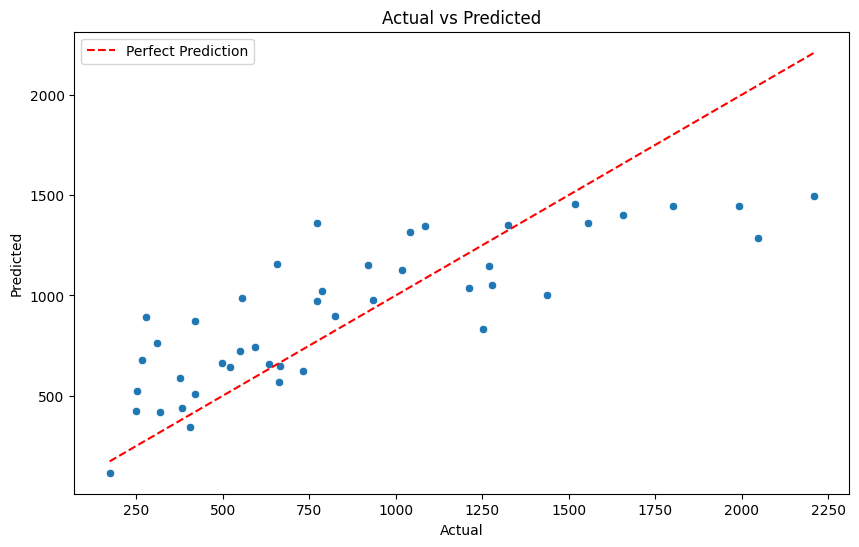

In [51]:
plot_actual_vs_predicted(y_test, test_pred_lr)

## Hyperparameter Tuning

In [52]:
param_grid_lr_tune = {'fit_intercept': [True, False]}
model = LinearRegression()
model_lr_tune, train_pred_lr_tune, test_pred_lr_tune, best_params_lr_tune = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid=param_grid_lr_tune)


R2 Score train : 0.6158509251708331
R2 Score test : 0.6458595534673881
MAE Score train : 217.87828191756455
MAE Score test : 250.87652336481798
RMSE Score train : 298.04734450869825
RMSE Score test : 316.9547999530748
MedAE Score train : 158.0484634875055
MedAE Score test : 196.0113727991623
MAPE Score train : 38.57%
MAPE Score test : 40.2%
Best Parameters : {'fit_intercept': True}


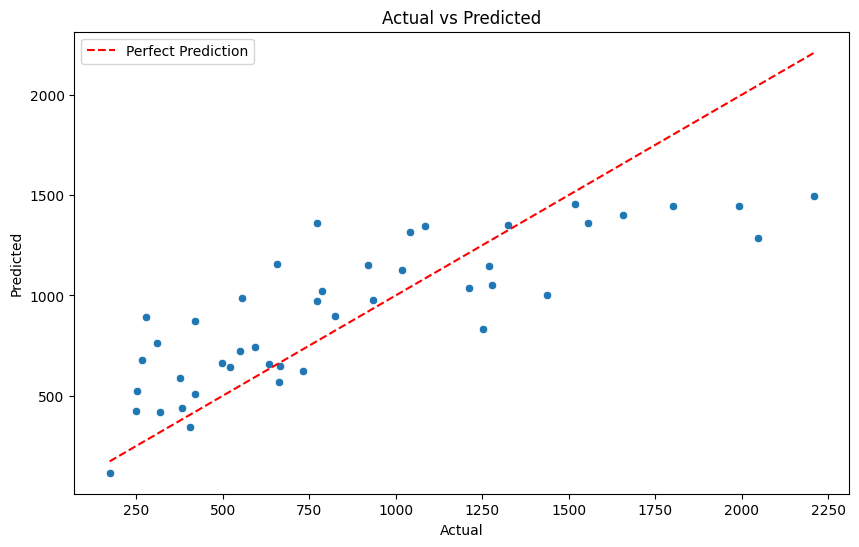

In [53]:
plot_actual_vs_predicted(y_test, test_pred_lr_tune)

# LASSO

In [54]:
model = Lasso()
model_lasso, train_pred_lasso, test_pred_lasso, best_params_lasso = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid={})

R2 Score train : 0.6157522986629718
R2 Score test : 0.6446541252748039
MAE Score train : 217.81899890344715
MAE Score test : 250.98183058154882
RMSE Score train : 298.08560241974266
RMSE Score test : 317.49376928984105
MedAE Score train : 155.13335814934828
MedAE Score test : 193.84097327633276
MAPE Score train : 38.67%
MAPE Score test : 40.15%
Best Parameters : {}


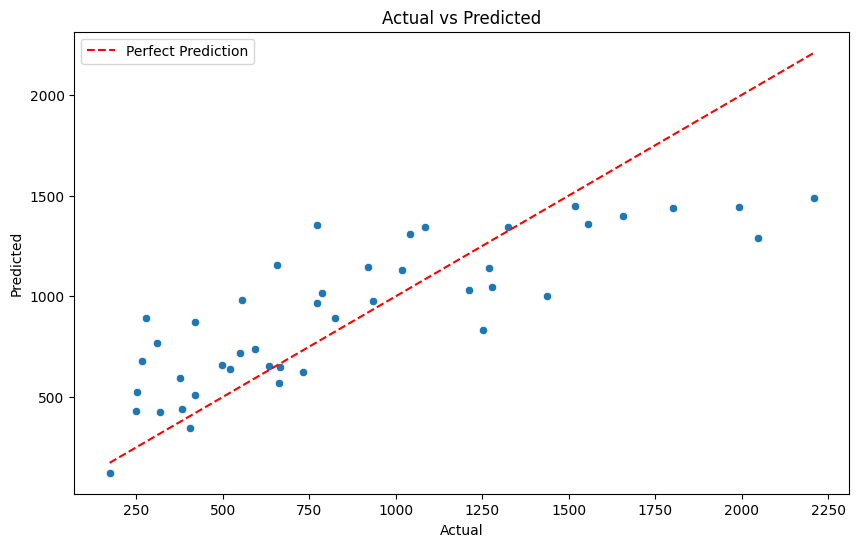

In [55]:
plot_actual_vs_predicted(y_test, test_pred_lasso)

## Hyperparameter Tuning

In [56]:
param_grid_lasso_tune = {
    'alpha': [0.1, 0.5, 1, 10, 100],
    'fit_intercept': [True, False],
    'max_iter': [1000, 5000],
    'selection': ['cyclic', 'random']  
}

model = Lasso()
model_lasso_tune, train_pred_lasso_tune, test_pred_lasso_tune, best_params_lasso_tune = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid=param_grid_lasso_tune)

R2 Score train : 0.6103640326392347
R2 Score test : 0.6509752349861873
MAE Score train : 217.72335592513784
MAE Score test : 244.61074000622986
RMSE Score train : 300.16833822441595
RMSE Score test : 314.65721142292216
MedAE Score train : 146.22688541626047
MedAE Score test : 168.24036271754375
MAPE Score train : 38.9%
MAPE Score test : 38.64%
Best Parameters : {'alpha': 10, 'fit_intercept': False, 'max_iter': 1000, 'selection': 'cyclic'}


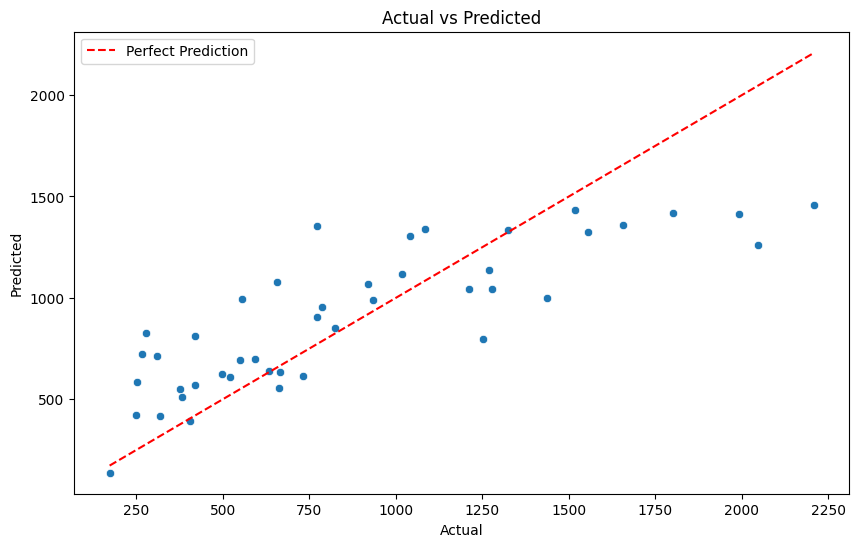

In [57]:
plot_actual_vs_predicted(y_test, test_pred_lasso_tune)

# Ridge

In [58]:
model = Ridge()
model_rid, train_pred_rid, test_pred_rid, best_params_rid = create_model(model, X_train_prepro, y_train, X_test_prepro,  y_test, param_grid={})

R2 Score train : 0.61573513236785
R2 Score test : 0.6442257005596389
MAE Score train : 218.14003551559819
MAE Score test : 250.92206284486556
RMSE Score train : 298.0922608437947
RMSE Score test : 317.6851056934285
MedAE Score train : 158.73554143371575
MedAE Score test : 199.55951031684384
MAPE Score train : 38.72%
MAPE Score test : 40.12%
Best Parameters : {}


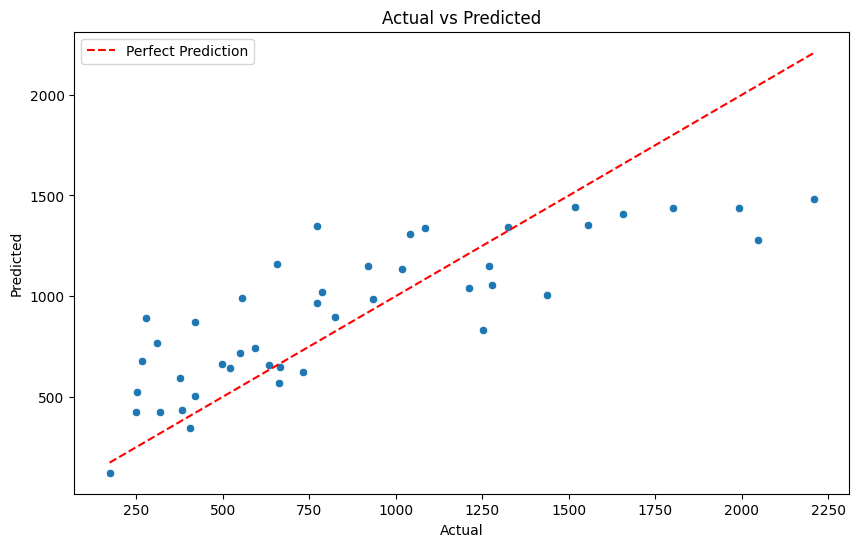

In [59]:
plot_actual_vs_predicted(y_test, test_pred_rid)

## Hyperparameter Tuning

In [60]:
param_grid_ridge = {
    'alpha': [0.1, 0.5, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga'],
    'max_iter': [1000, 5000]
}

model = Ridge()
model_rid_tune, train_pred_rid_tune, test_pred_rid_tune, best_params_rid_tune = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid=param_grid_ridge)

R2 Score train : 0.5627910309608606
R2 Score test : 0.5871572406400378
MAE Score train : 224.78578709356142
MAE Score test : 250.59364074720753
RMSE Score train : 317.9654207253923
RMSE Score test : 342.21725538434674
MedAE Score train : 159.68618341405318
MedAE Score test : 152.99157431636237
MAPE Score train : 40.26%
MAPE Score test : 36.51%
Best Parameters : {'alpha': 100, 'fit_intercept': False, 'max_iter': 1000, 'solver': 'lsqr'}


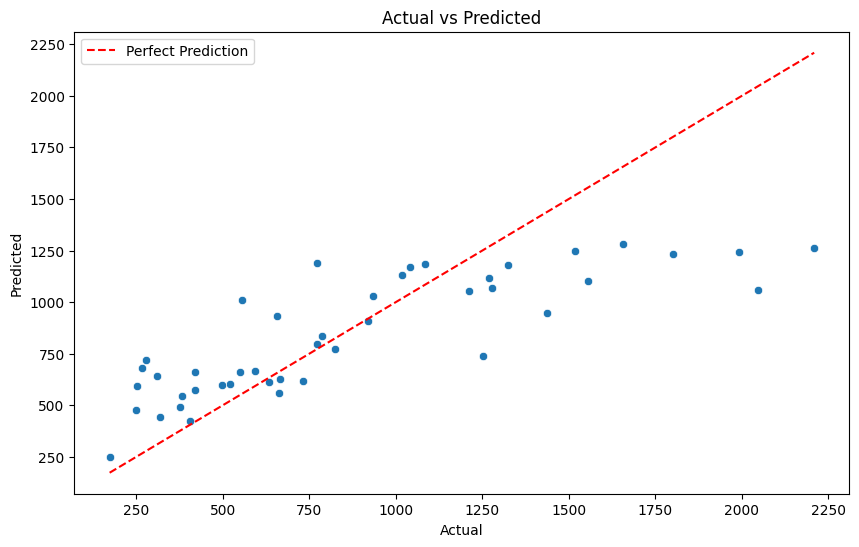

In [61]:
plot_actual_vs_predicted(y_test, test_pred_rid_tune)

# SVR

In [62]:
from sklearn.svm import SVR

In [63]:
model = SVR()
model_svm, train_pred_svm, test_pred_svm, best_params_svm = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid={})

R2 Score train : 0.018417310135199205
R2 Score test : -0.05539100707891764
MAE Score train : 344.61193846812546
MAE Score test : 416.9566161537343
RMSE Score train : 476.42967751616067
RMSE Score test : 547.162420964408
MedAE Score train : 271.04653559668066
MedAE Score test : 321.1279519092053
MAPE Score train : 68.22%
MAPE Score test : 59.67%
Best Parameters : {}


In [64]:
param_grid_svr_tune = {
    'C': [0.1, 1, 10, 100],           # Regularization parameter
    'epsilon': [0.1, 0.2, 0.5, 1.0], # Epsilon in the epsilon-SVR model
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # Kernel type
    'degree': [2, 3, 4],              # Degree for 'poly' kernel
    'gamma': ['scale', 'auto'],       # Kernel coefficient
    'coef0': [0.0, 0.1, 0.5],         # Independent term in kernel function
}

model = SVR()
model_svr_tune, train_pred_svr_tune, test_pred_svr_tune, best_params_svr_tune = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid=param_grid_svr_tune)

R2 Score train : 0.7028600643426206
R2 Score test : 0.7044794438731876
MAE Score train : 184.93238308003797
MAE Score test : 213.09279959399737
RMSE Score train : 262.1294845286677
RMSE Score test : 289.5365635294338
MedAE Score train : 137.89203351872357
MedAE Score test : 145.83854019140597
MAPE Score train : 29.78%
MAPE Score test : 29.76%
Best Parameters : {'C': 100, 'coef0': 0.5, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'}


# Random Forest

In [65]:
model = RandomForestRegressor()
model_rf, train_pred_rf, test_pred_rf, best_params_rf = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid={})

R2 Score train : 0.9514760659279277
R2 Score test : 0.7375577093473533
MAE Score train : 75.9584105142858
MAE Score test : 204.90585272727284
RMSE Score train : 105.92863182887744
RMSE Score test : 272.8515829464221
MedAE Score train : 52.511199999999235
MedAE Score test : 169.55040000000025
MAPE Score train : 14.07%
MAPE Score test : 30.23%
Best Parameters : {}


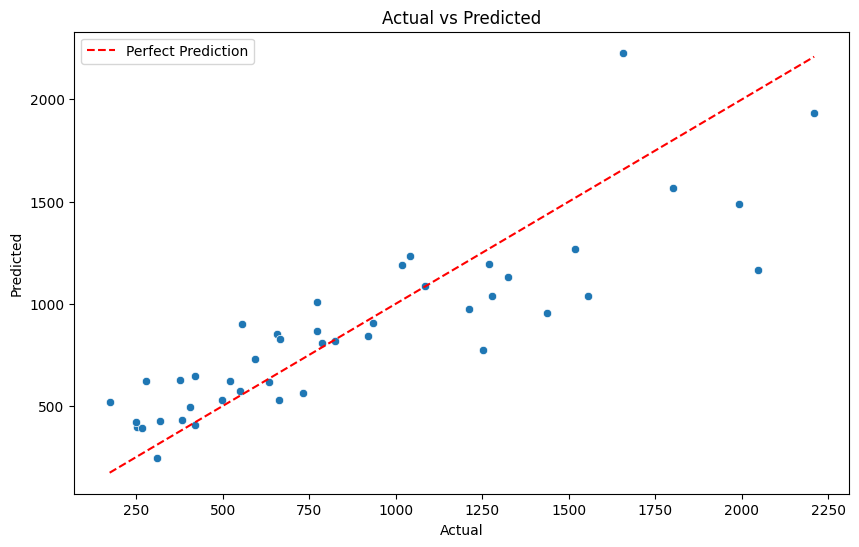

In [66]:
plot_actual_vs_predicted(y_test, test_pred_rf)

## Hyperparameter Tunning

In [67]:
param_grid_rf_tune = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}

model = RandomForestRegressor()
model_rf_tune, train_pred_rf_tune, test_pred_rf_tune, best_params_rf_tune = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid=param_grid_rf_tune)

R2 Score train : 0.9172007304453907
R2 Score test : 0.7657064930594177
MAE Score train : 97.4878966550001
MAE Score test : 178.48544793251176
RMSE Score train : 138.37212602890423
RMSE Score test : 257.80402546050453
MedAE Score train : 70.25930714285721
MedAE Score test : 124.51350764400195
MAPE Score train : 17.35%
MAPE Score test : 25.69%
Best Parameters : {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}


d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
646 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\sklearn\base.py", line 666, in

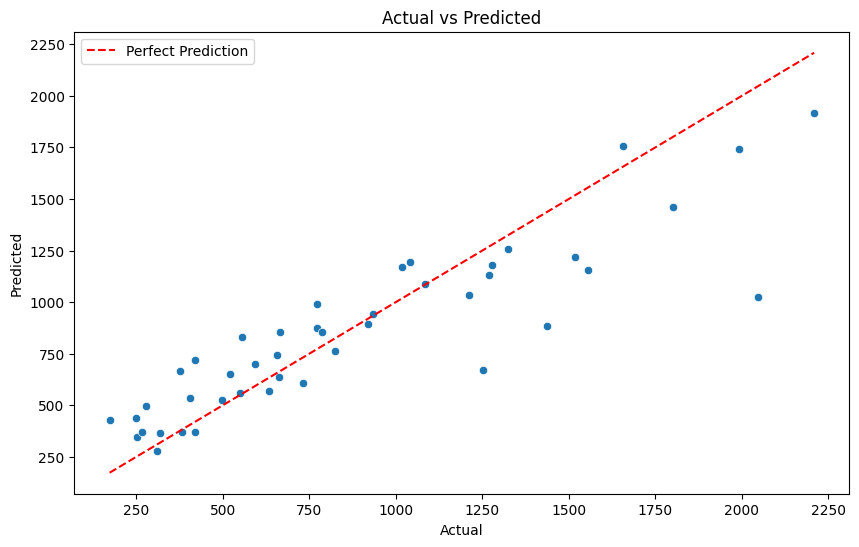

In [68]:
plot_actual_vs_predicted(y_test, test_pred_rf_tune)

# XGBoost

In [69]:
model = XGBRegressor()
model_xg, train_pred_xg, test_pred_xg, best_params_xg = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid={})

R2 Score train : 0.9999933560050511
R2 Score test : 0.6929551794975849
MAE Score train : 0.827648244280134
MAE Score test : 220.32935958862302
RMSE Score train : 1.2395099226927075
RMSE Score test : 295.1280278202571
MedAE Score train : 0.44403808593756366
MedAE Score test : 160.50874511718752
MAPE Score train : 0.15%
MAPE Score test : 33.56%
Best Parameters : {}


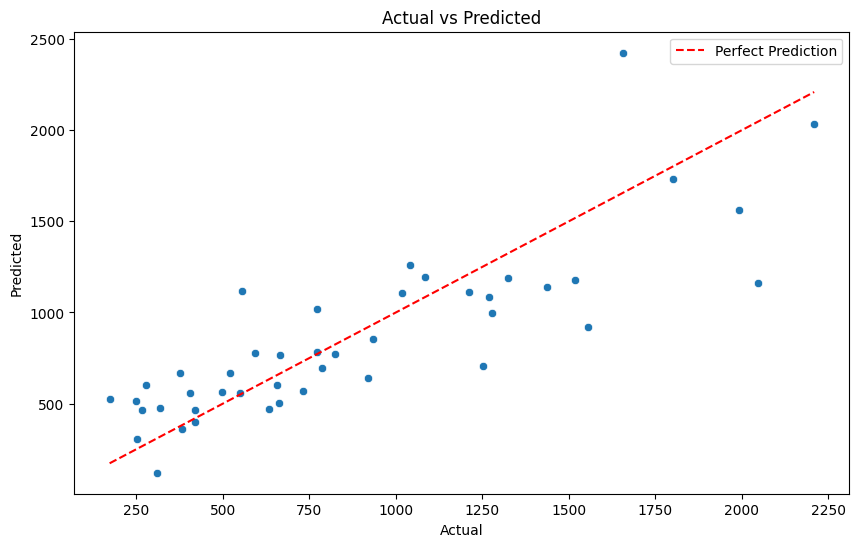

In [70]:
plot_actual_vs_predicted(y_test, test_pred_xg)

In [71]:
param_grid_xg_tune = {
    'n_estimators': [100, 200, 300],         # Jumlah pohon (cukup spesifik dan tidak terlalu besar)
    'max_depth': [3, 5, 7],                  # Kedalaman maksimum (menengah)
    'learning_rate': [0.05, 0.1],            # Kecepatan pembelajaran umum
    'subsample': [0.8, 1.0],                 # Proporsi data (penting untuk mencegah overfitting)
    'colsample_bytree': [0.8, 1.0],          # Proporsi fitur
    'min_child_weight': [1, 3]               # Minimum data di leaf node (nilai kecil)
}

model = XGBRegressor()
model_xg_tune, train_pred_xg_tune, test_pred_xg_tune, best_params_xg_tune = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid=param_grid_xg_tune)

R2 Score train : 0.9256955441456389
R2 Score test : 0.7996371948153322
MAE Score train : 101.27376525669641
MAE Score test : 175.41779038862748
RMSE Score train : 131.08191880154135
RMSE Score test : 238.40651511817663
MedAE Score train : 75.90936523437495
MedAE Score test : 114.94112182617192
MAPE Score train : 18.42%
MAPE Score test : 26.8%
Best Parameters : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


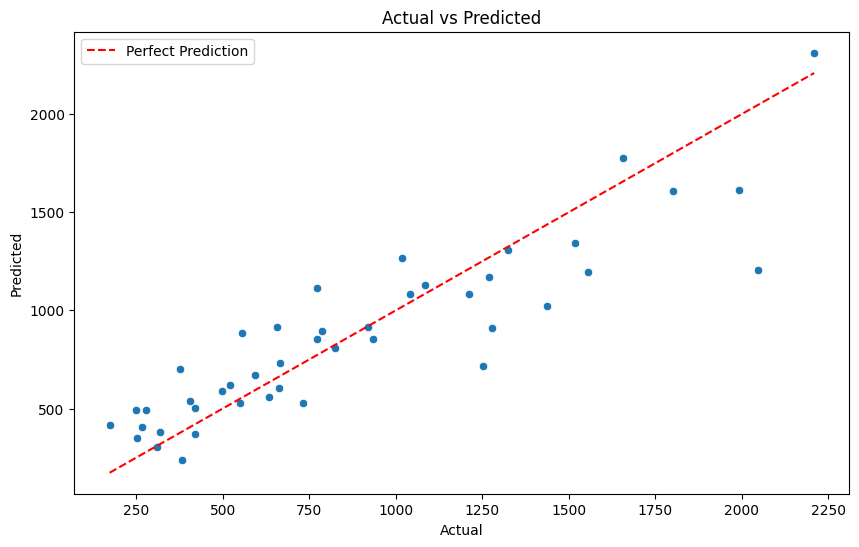

In [72]:
plot_actual_vs_predicted(y_test, test_pred_xg_tune)

# LGBM

In [73]:
model = LGBMRegressor()
model_lm, train_pred_lm, test_pred_lm, best_params_lm = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid={})

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 11
[LightGBM] [Info] Start training from score 781.210993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

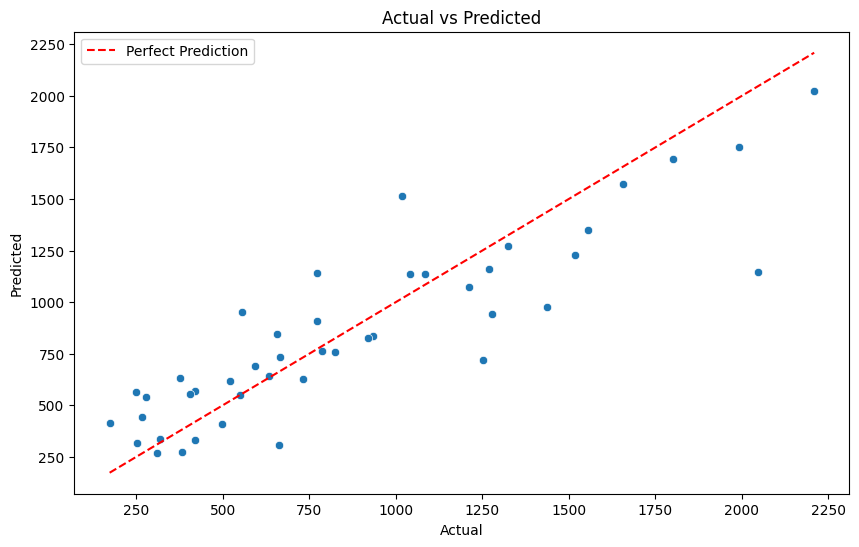

In [74]:
plot_actual_vs_predicted(y_test, test_pred_lm)

In [75]:
param_grid_lm_tune = {
    'n_estimators': [100, 200],            # Jumlah boosting iterations, rentang optimal dan cepat
    'learning_rate': [0.05, 0.1],          # Fokus pada kecepatan pembelajaran sedang
    'max_depth': [5, 10],                  # Pilihan kedalaman rendah-sedang
    'num_leaves': [31, 50],                # Jumlah maksimum leaf nodes optimal
    'min_child_samples': [10, 20],         # Minimum sample pada leaf node untuk stabilisasi
    'subsample': [0.8, 1.0],               # Subsampling untuk generalisasi lebih baik
    'colsample_bytree': [0.8, 1.0],        # Subsampling kolom untuk generalisasi
    'reg_alpha': [0.0, 0.1],               # L1 regularisasi sederhana
    'reg_lambda': [0.1, 0.5]               # L2 regularisasi untuk balancing kompleksitas
}

model = LGBMRegressor()
model_lm_tune, train_pred_lm_tune, test_pred_lm_tune, best_params_lm_tune = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid=param_grid_lm_tune)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 11
[LightGBM] [Info] Start training from score 781.210993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

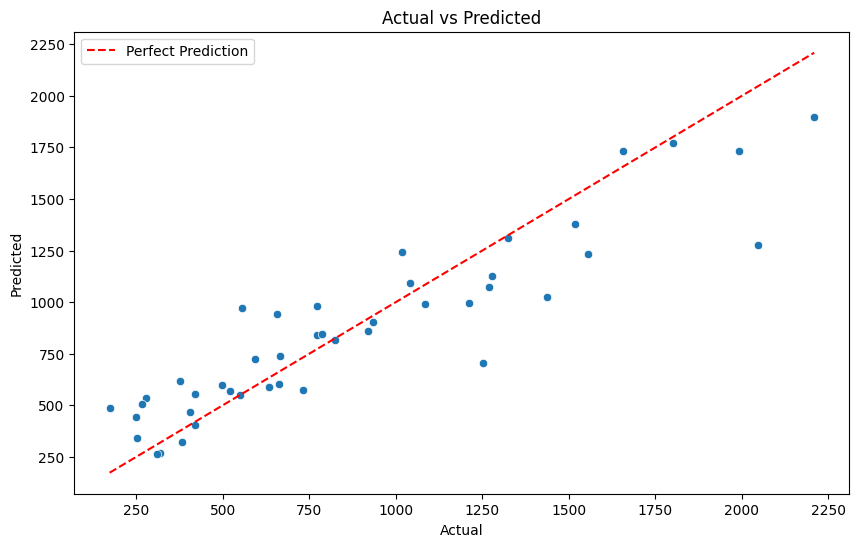

In [76]:
plot_actual_vs_predicted(y_test, test_pred_lm_tune)

# Ensamble Stacking

In [77]:
base_model = [
    ('rf', RandomForestRegressor(**best_params_rf_tune, random_state=72)),
    ('xgb', XGBRegressor(**best_params_xg_tune)),
    ('lgbm', LGBMRegressor(**best_params_lm_tune))
    #('ridge', Ridge(alpha=10, fit_intercept=False, max_iter=5000, solver='saga')),
    #('svr', SVR(C=100, coef0=0.0, degree=2, epsilon=1.0, gamma='scale',kernel='linear' )),
    #('lasso', Lasso()),
    # ('lr', LinearRegression())
    # ('knn', KNeighborsRegressor(n_neighbors=5)).
    # ('dt', DecisionTreeRegressor())
]

meta_model = SVR(kernel='linear') 

model = StackingRegressor(estimators=base_model, final_estimator=meta_model, cv=5)
model_stc, train_pred_stc, test_pred_stc, best_params_stc = create_model(model, X_train_prepro, y_train, X_test_prepro, y_test, param_grid={})

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 11
[LightGBM] [Info] Start training from score 781.210993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

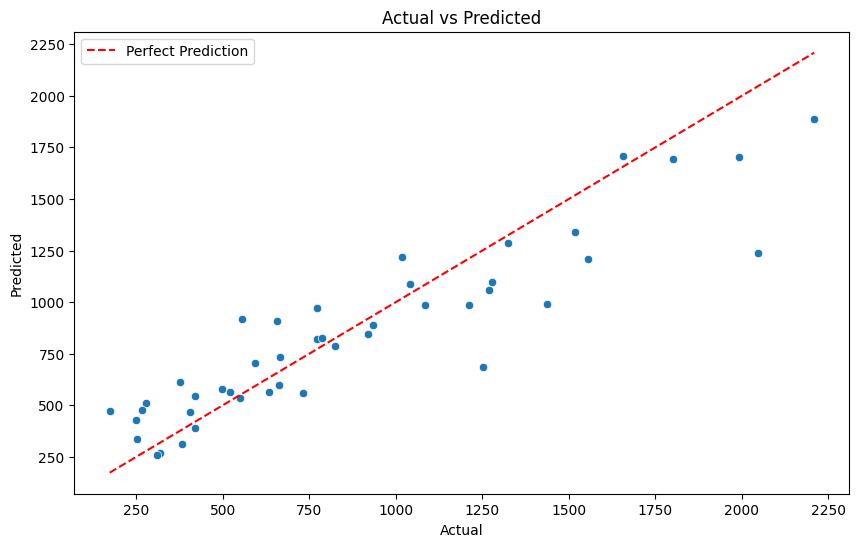

In [78]:
plot_actual_vs_predicted(y_test, test_pred_stc)

In [79]:
prediction_dict = {'Actual' : y_test,
                   'Pred_lr' : test_pred_lr,
                   'Pred_lasso' : test_pred_lasso_tune,
                   'Pred_ridge' : test_pred_rid_tune,
                   'Pred_rf' : test_pred_rf_tune,
                    'Pred_svr' : test_pred_svr_tune,
                    'Pred_xgb' : test_pred_xg_tune,
                    'Pred_lgbm' : test_pred_lm_tune,
                    'Pred_stack_model': test_pred_stc }

df_predict = pd.DataFrame(prediction_dict)
df_predict

,Actual,Pred_lr,Pred_lasso,Pred_ridge,Pred_rf,Pred_svr,Pred_xgb,Pred_lgbm,Pred_stack_model
82,771.92,969.605168,905.999101,794.678416,873.353083,903.189702,852.555969,840.987203,823.183496
117,276.92,892.504046,826.829692,721.414747,494.524698,678.323332,494.049622,533.612839,511.093183
202,1516.90,1453.261781,1432.612761,1246.842585,1218.674052,1357.424577,1341.136353,1376.649814,1338.301056
216,658.00,1156.691750,1075.980514,933.770803,741.944235,965.195162,917.374268,943.349753,907.860145
69,664.61,647.647433,632.342737,625.818045,856.080397,631.403843,733.829590,740.998124,736.299523
119,933.61,976.285095,988.355626,1030.857022,941.672787,848.854291,855.323486,905.095933,888.807178
89,1554.23,1359.892423,1325.601152,1103.296545,1153.594518,1234.073169,1193.827759,1234.346141,1207.996583
74,1211.54,1038.077867,1044.626237,1053.612020,1036.333807,996.956109,1083.503052,993.487882,986.084967
133,2208.83,1492.810293,1456.175128,1260.020621,1918.893964,1476.340236,2312.081787,1898.093741,1887.864919
107,1436.54,1002.770221,998.934268,948.152795,883.043447,961.937873,1022.650269,1025.254456,992.196804


In [80]:
output_columns

['DAY_RUN',
 'RR',
 'AVG_T_RETURN',
 'AVG_FRC',
 'AVG_CHLORIDE',
 'CONDUCT LIMIT',
 'BACTERIA_STATUS',
 'FUNCTION',
 'Cuprum',
 'Galvanized',
 'Stainless steel']

# Preprocessing add feature

In [81]:
# Column Definitions
ohe_columns = ['FUNCTION']
transform_columns = ['CONDUCT LIMIT']
label_columns = ['BACTERIA_STATUS']
num_columns = [col for col in df_tes.select_dtypes('number').columns if col not in ['NAOCL', 'CONDUCT LIMIT', 'RR', 'AVG_FRC']]
material_columns = ['MATERIAL']
add_columns = ['RR', 'AVG_FRC', 'AVG_CHLORIDE']

In [82]:
# Output columns
output_columns = (
    num_columns +
    transform_columns +
    label_columns +
    ['FUNCTION'] +
    ['Cuprum', 'Galvanized', 'Stainless steel'] +
    add_columns +
    ['RR_AVG_FRC', 'AVG_FRC_CHLORIDE']
)

In [83]:
output_columns

['DAY_RUN',
 'AVG_T_RETURN',
 'AVG_CHLORIDE',
 'CONDUCT LIMIT',
 'BACTERIA_STATUS',
 'FUNCTION',
 'Cuprum',
 'Galvanized',
 'Stainless steel',
 'RR',
 'AVG_FRC',
 'AVG_CHLORIDE',
 'RR_AVG_FRC',
 'AVG_FRC_CHLORIDE']

In [84]:
# CategoriConduct Transformer
class CategoriConduct(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ubah array menjadi DataFrame jika perlu
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.applymap(lambda x: 1 if x <= 700 else 2 if x <= 1200 else 3)

In [85]:
# Label Encoding Transformer
class LabelEncode(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mapping = {'Acceptable': 2, 'Not Acceptable': 1, 'low': 1, 'medium': 2, 'high': 3}
        return self
    
    def transform(self, X):
        return X.replace(self.mapping)

In [86]:
# Material encoder
class MaterialEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        """
        Inisialisasi encoder.

        Parameters:
        column_name (str): Nama kolom yang ingin diproses.
        """
        self.column_name = column_name
        self.mlb = MultiLabelBinarizer()
        self.classes_ = None

    def fit(self, X, y=None):
        """
        Fit MultiLabelBinarizer ke data.

        Parameters:
        X (pd.DataFrame): DataFrame input.

        Returns:
        self
        """
        X = self._preprocess_column(X)
        self.mlb.fit(X[self.column_name])
        self.classes_ = self.mlb.classes_
        return self

    def transform(self, X):
        """
        Transform kolom target menjadi one-hot encoding.

        Parameters:
        X (pd.DataFrame): DataFrame input.

        Returns:
        pd.DataFrame: Hasil encoding dengan bahan unik sebagai kolom.
        """
        X = self._preprocess_column(X)
        encoded_data = self.mlb.transform(X[self.column_name])
        encoded_df = pd.DataFrame(encoded_data, columns=self.classes_, index=X.index)
        return encoded_df

    def _preprocess_column(self, X):
        """
        Preprocess kolom: ubah list-string menjadi list Python (jika diperlukan).

        Parameters:
        X (pd.DataFrame): DataFrame input.

        Returns:
        pd.DataFrame: DataFrame dengan list bahan.
        """
        X = X.copy()
        X[self.column_name] = X[self.column_name].apply(
            lambda x: x if isinstance(x, list) else (
                ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else []
            )
        )
        return X

In [87]:
# class add feature RR_AVG_FRC
class AddFeature(BaseEstimator, TransformerMixin):
    def __init__(self, rr, avg_frc, avg_chloride):
        self.rr = rr
        self.avg_frc = avg_frc
        self.avg_chloride = avg_chloride
        self.avg_frc_chloride = f"{self.avg_frc}_{self.avg_chloride}"
        self.rr_avg_frc = f"{self.rr}_{self.avg_frc}" 

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        X = X.copy()
        X[self.rr_avg_frc] = X[self.rr] * X[self.avg_frc]
        X[self.avg_frc_chloride] = X[self.avg_frc] * X[self.avg_chloride]

        return X[[self.rr, self.avg_frc, self.rr_avg_frc, self.avg_frc_chloride]]

In [88]:
tes = AddFeature(rr='RR', avg_frc='AVG_FRC', avg_chloride='AVG_CHLORIDE')
testing = tes.fit_transform(df_tes)
testing

,RR,AVG_FRC,RR_AVG_FRC,AVG_FRC_AVG_CHLORIDE
0,400,0.21,84.00,33.1947
1,2400,0.19,456.00,55.8353
2,450,0.19,85.50,35.1633
3,700,0.26,182.00,33.0824
4,2496,0.14,349.44,33.6336
...,...,...,...,...
215,624,0.56,349.44,93.3912
216,1500,1.00,1500.00,184.0000
217,2000,0.36,720.00,55.0440
218,2500,0.76,1900.00,129.8080


In [89]:
# Pipeline
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categori_conduct_pipeline = Pipeline(steps=[
    ('categorize', CategoriConduct())
])

label_pipeline = Pipeline(steps=[
    ('label_encode', LabelEncode())
])

material_pipeline = Pipeline(steps=[
    ('binarizer', MaterialEncoder(column_name='MATERIAL'))  
])

ohe_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder())
])

add_feature = Pipeline(steps=[
    ('rr_avg_frc', AddFeature(rr='RR', avg_frc='AVG_FRC', avg_chloride='AVG_CHLORIDE')),
    ('scaler', StandardScaler())
])

# Combine Pipelines into ColumnTransformer
preprocessor_new = ColumnTransformer(transformers=[
    ('numeric_pipeline', numeric_pipeline, num_columns),
    ('conduct_category', categori_conduct_pipeline, transform_columns),
    ('label_encode', label_pipeline, label_columns),
    ('ohe', ohe_pipeline, ohe_columns),
    ('material_binarizer', material_pipeline, material_columns),
    ('add_feature', add_feature, add_columns)
])


In [90]:
X_train_new = preprocessor_new.fit_transform(X_train)
X_test_new = preprocessor_new.transform(X_test)

C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\2900693823.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: 1 if x <= 700 else 2 if x <= 1200 else 3)
C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\757229385.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return X.replace(self.mapping)
C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\2900693823.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(lambda x: 1 if x <= 700 else 2 if x <= 1200 else 3)
C:\Users\I Gusti Ayu Melinia\AppData\Local\Temp\ipykernel_8668\757229385.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated 

In [91]:
len(X_train_new[0])

14

# Linear Regression

In [92]:
model = LinearRegression()
model_lr_new, train_pred_lr_new, test_pred_lr_new, best_params_lr_new = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid={})

R2 Score train : 0.6857339151106829
R2 Score test : 0.594097856551723
MAE Score train : 204.1518370187453
MAE Score test : 254.74854811354916
RMSE Score train : 269.57779615887773
RMSE Score test : 339.32842410285355
MedAE Score train : 143.28962448369316
MedAE Score test : 194.10513478695856
MAPE Score train : 36.88%
MAPE Score test : 41.36%
Best Parameters : {}


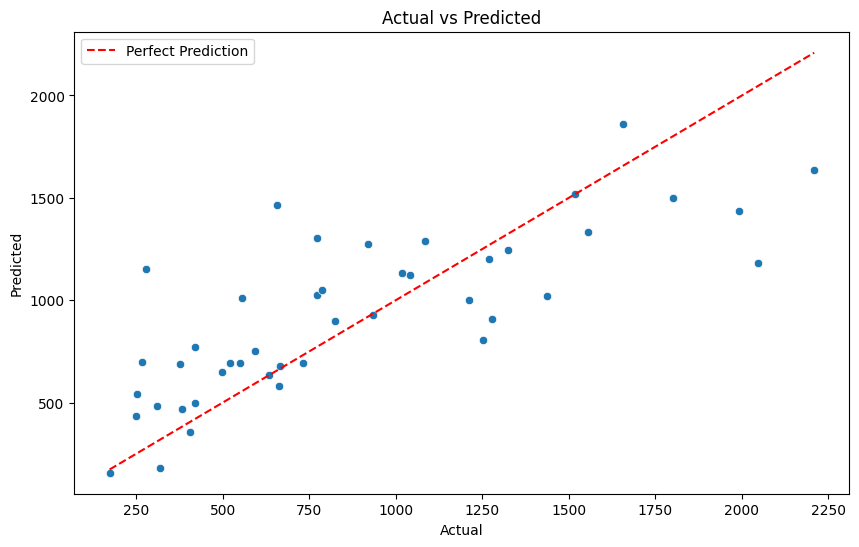

In [93]:
plot_actual_vs_predicted(y_test, test_pred_lr_new)

## Hyperparameter Tuning

In [94]:
param_grid_lr_new_tune = {'fit_intercept': [True, False]}
model = LinearRegression()
model_lr_new_tune, train_pred_lr_new_tune, test_pred_lr_new_tune, best_params_lr_new_tune = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid=param_grid_lr_new_tune)


R2 Score train : 0.6857339151106829
R2 Score test : 0.594097856551723
MAE Score train : 204.1518370187453
MAE Score test : 254.74854811354916
RMSE Score train : 269.57779615887773
RMSE Score test : 339.32842410285355
MedAE Score train : 143.28962448369316
MedAE Score test : 194.10513478695856
MAPE Score train : 36.88%
MAPE Score test : 41.36%
Best Parameters : {'fit_intercept': True}


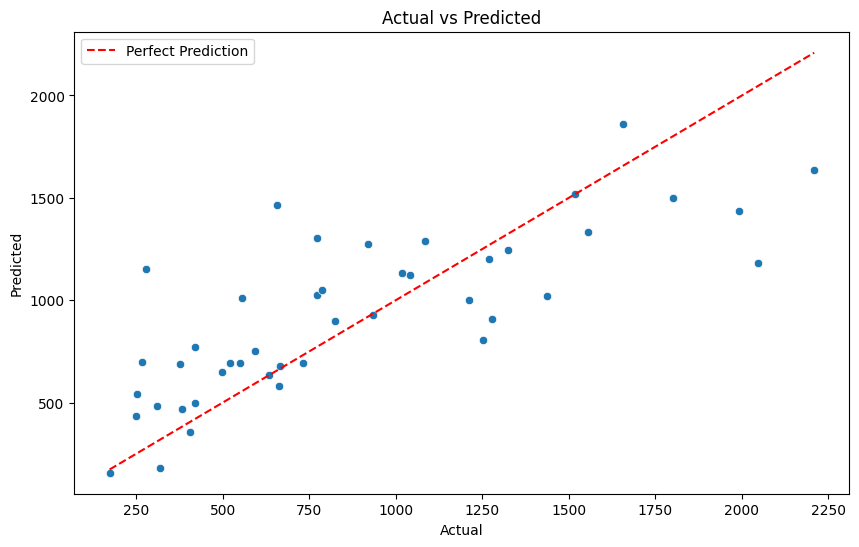

In [95]:
plot_actual_vs_predicted(y_test, test_pred_lr_new_tune)

# LASSO

In [96]:
model = Lasso()
model_lasso_new, train_pred_lasso_new, test_pred_lasso_new, best_params_lasso_new = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid={})

R2 Score train : 0.6852525863754786
R2 Score test : 0.5904693614292347
MAE Score train : 204.0703890226644
MAE Score test : 254.95043805865524
RMSE Score train : 269.78415933428806
RMSE Score test : 340.84173481068774
MedAE Score train : 144.23528812245786
MedAE Score test : 193.0135485785775
MAPE Score train : 36.75%
MAPE Score test : 41.24%
Best Parameters : {}


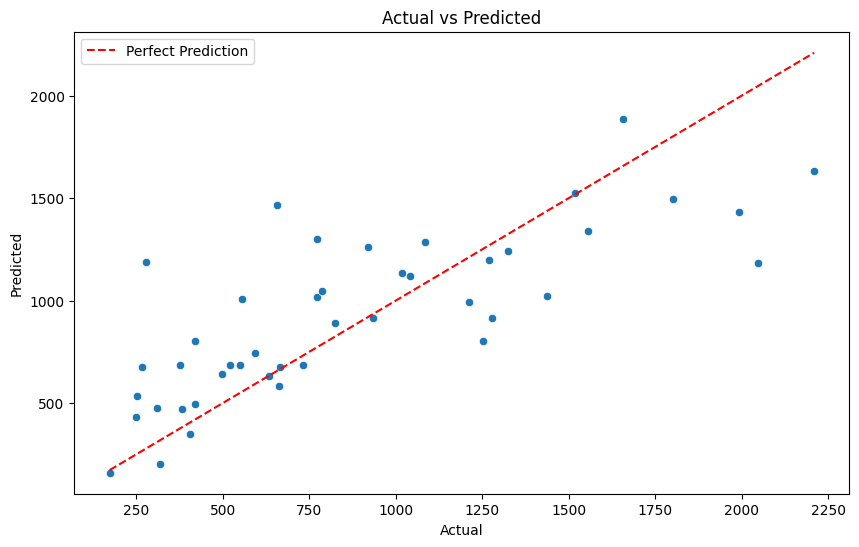

In [97]:
plot_actual_vs_predicted(y_test, test_pred_lasso_new)

In [98]:
param_grid_lasso_new_tune = {
    'alpha': [0.1, 0.5, 1, 10, 100],
    'fit_intercept': [True, False],
    'max_iter': [1000, 5000],
    'selection': ['cyclic', 'random']  
}

model = Lasso()
model_lasso_new_tune, train_pred_lasso_new_tune, test_pred_lasso_new_tune, best_params_lasso_new_tune = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid=param_grid_lasso_new_tune)

R2 Score train : 0.6623322267082681
R2 Score test : 0.6075217284177823
MAE Score train : 208.16731024437766
MAE Score test : 246.1133822706931
RMSE Score train : 279.43459219661014
RMSE Score test : 333.67016566774487
MedAE Score train : 159.91396578643753
MedAE Score test : 167.7032815312062
MAPE Score train : 36.29%
MAPE Score test : 39.7%
Best Parameters : {'alpha': 10, 'fit_intercept': False, 'max_iter': 5000, 'selection': 'random'}


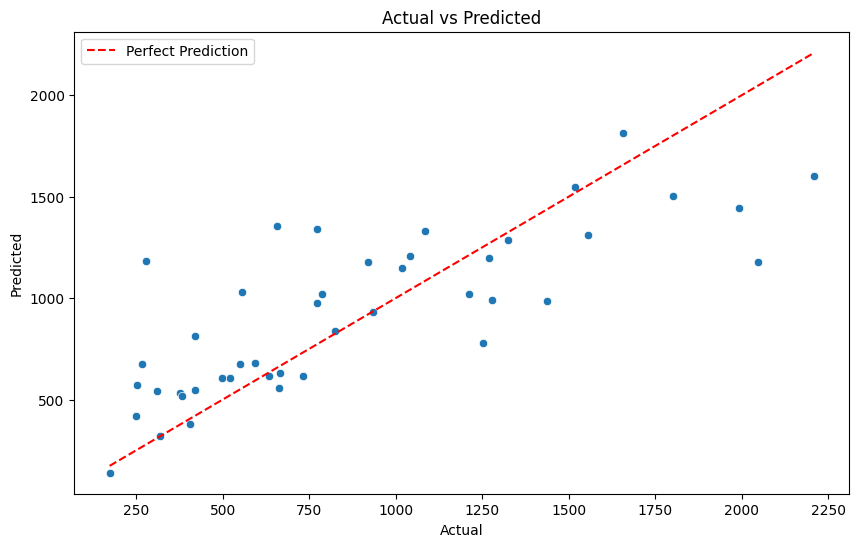

In [99]:
plot_actual_vs_predicted(y_test, test_pred_lasso_new_tune)

# Ridge

In [100]:
model = Ridge()
model_rid_new, train_pred_rid_new, test_pred_rid_new, best_params_rid_new = create_model(model, X_train_new, y_train, X_test_new,  y_test, param_grid={})

R2 Score train : 0.6853402085004241
R2 Score test : 0.5915984837332481
MAE Score train : 204.3947334761323
MAE Score test : 254.5985208105126
RMSE Score train : 269.7466042889801
RMSE Score test : 340.3715408800109
MedAE Score train : 142.62661016469588
MedAE Score test : 193.22312249457292
MAPE Score train : 36.74%
MAPE Score test : 41.16%
Best Parameters : {}


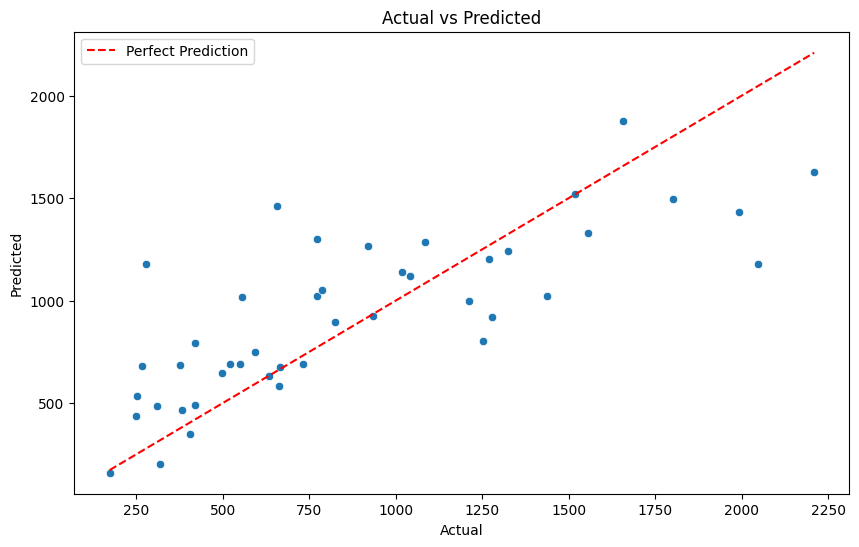

In [101]:
plot_actual_vs_predicted(y_test, test_pred_rid_new)

In [102]:
param_grid_rid_new = {
    'alpha': [0.1, 0.5, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga'],
    'max_iter': [1000, 5000]
}

model = Ridge()
model_rid_new_tune, train_pred_rid_new_tune, test_pred_rid_new_tune, best_params_rid_new_tune = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid=param_grid_rid_new)

R2 Score train : 0.6209254424761257
R2 Score test : 0.573492895505701
MAE Score train : 218.5201751951403
MAE Score test : 249.7509503436036
RMSE Score train : 296.0722331061245
RMSE Score test : 347.83453793684697
MedAE Score train : 171.628785234982
MedAE Score test : 144.28446427236355
MAPE Score train : 37.99%
MAPE Score test : 38.05%
Best Parameters : {'alpha': 100, 'fit_intercept': False, 'max_iter': 1000, 'solver': 'auto'}


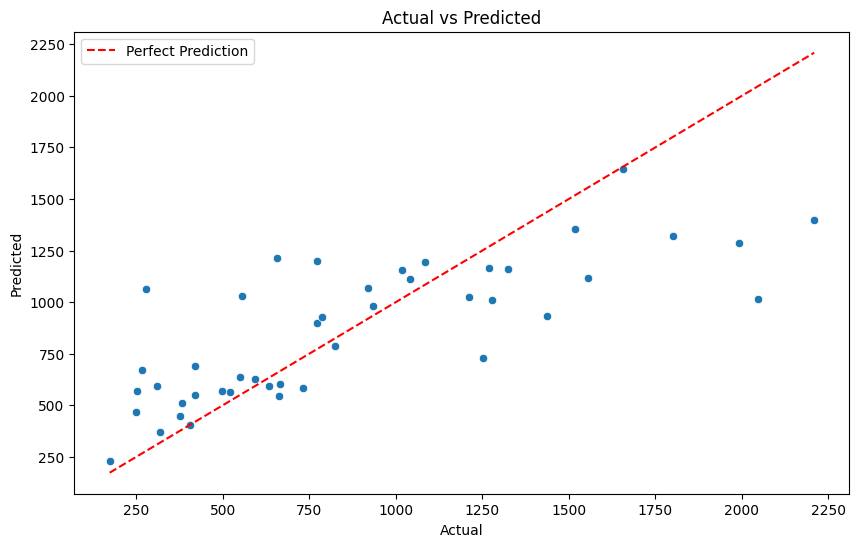

In [103]:
plot_actual_vs_predicted(y_test, test_pred_rid_new_tune)

# XGBoost

In [104]:
model = XGBRegressor()
model_xg_new, train_pred_xg_new, test_pred_xg_new, best_params_xg_new = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid={})

R2 Score train : 0.9999997231754063
R2 Score test : 0.6463840833455248
MAE Score train : 0.17215720424106945
MAE Score test : 230.0853632146662
RMSE Score train : 0.2530100057924398
RMSE Score test : 316.7199865190633
MedAE Score train : 0.09858886718757276
MedAE Score test : 193.59268066406256
MAPE Score train : 0.03%
MAPE Score test : 37.34%
Best Parameters : {}


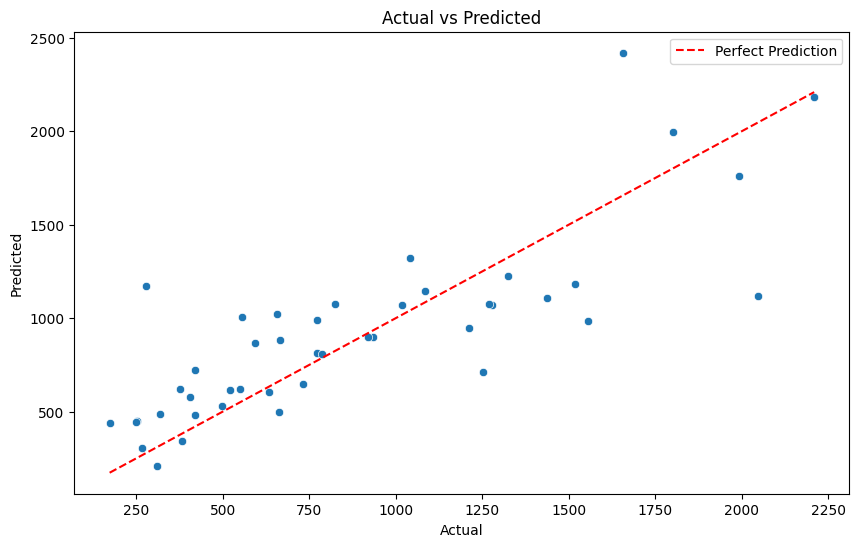

In [105]:
plot_actual_vs_predicted(y_test, test_pred_xg_new)

In [106]:
param_grid_xg_new_tune = {
    'n_estimators': [100, 200, 300],         # Jumlah pohon (cukup spesifik dan tidak terlalu besar)
    'max_depth': [3, 5, 7],                  # Kedalaman maksimum (menengah)
    'learning_rate': [0.05, 0.1],            # Kecepatan pembelajaran umum
    'subsample': [0.8, 1.0],                 # Proporsi data (penting untuk mencegah overfitting)
    'colsample_bytree': [0.8, 1.0],          # Proporsi fitur
    'min_child_weight': [1, 3]               # Minimum data di leaf node (nilai kecil)
}

model = XGBRegressor()
model_xg_new_tune, train_pred_xg_new_tune, test_pred_xg_new_tune, best_params_xg_new_tune = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid=param_grid_xg_new_tune)

R2 Score train : 0.9077469024427848
R2 Score test : 0.7316165149937573
MAE Score train : 111.72982118303571
MAE Score test : 212.16113300670276
RMSE Score train : 146.05816484281414
RMSE Score test : 275.9227195123366
MedAE Score train : 87.88458496093745
MedAE Score test : 169.6451831054687
MAPE Score train : 21.48%
MAPE Score test : 30.85%
Best Parameters : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


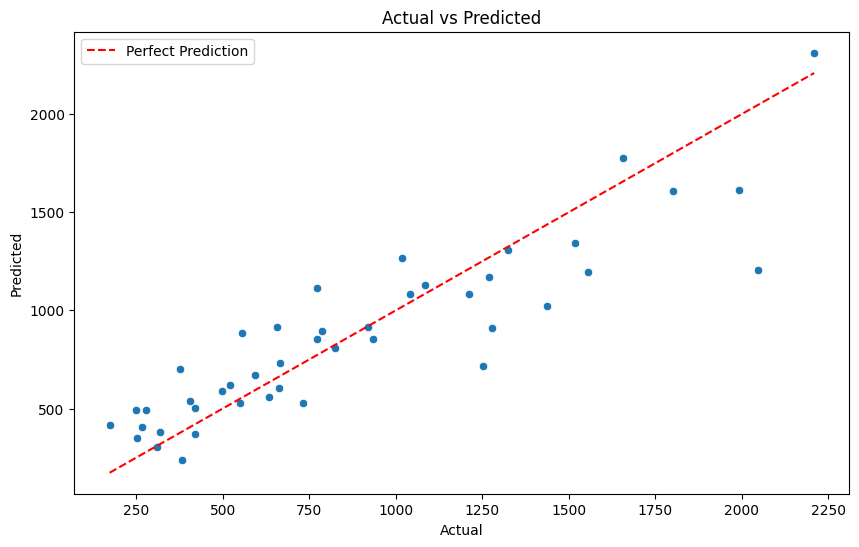

In [107]:
plot_actual_vs_predicted(y_test, test_pred_xg_tune)

# Random Forest

In [108]:
model = RandomForestRegressor()
model_rf_new, train_pred_rf_new, test_pred_rf_new, best_params_rf_new = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid={})

R2 Score train : 0.9504091657720694
R2 Score test : 0.7133714296437335
MAE Score train : 76.71073451428578
MAE Score test : 220.74800909090908
RMSE Score train : 107.08683132004985
RMSE Score test : 285.1473281557187
MedAE Score train : 50.880499999999756
MedAE Score test : 155.95895000000004
MAPE Score train : 13.96%
MAPE Score test : 31.77%
Best Parameters : {}


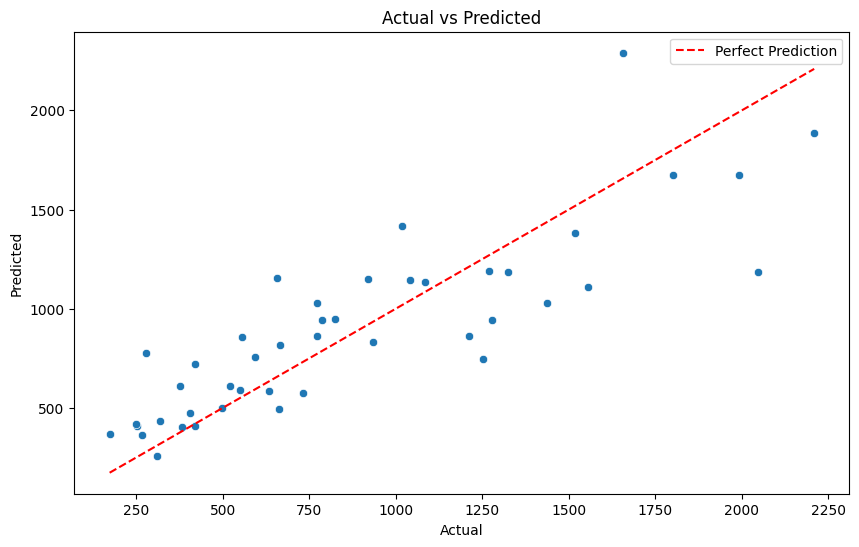

In [109]:
plot_actual_vs_predicted(y_test, test_pred_rf_new)

## Hyperparameter Tunning

In [110]:
param_grid_rf_new_tune = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}

model = RandomForestRegressor()
model_rf_new_tune, train_pred_rf_new_tune, test_pred_rf_new_tune, best_params_rf_new_tune = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid=param_grid_rf_new_tune)

d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
489 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\sklearn\base.py", line 666, in

R2 Score train : 0.876962447141532
R2 Score test : 0.7923199217190814
MAE Score train : 117.33114219080831
MAE Score test : 185.54198779652606
RMSE Score train : 168.67635334748675
RMSE Score test : 242.72079573448755
MedAE Score train : 84.21089526963806
MedAE Score test : 144.39992490079408
MAPE Score train : 21.12%
MAPE Score test : 27.31%
Best Parameters : {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


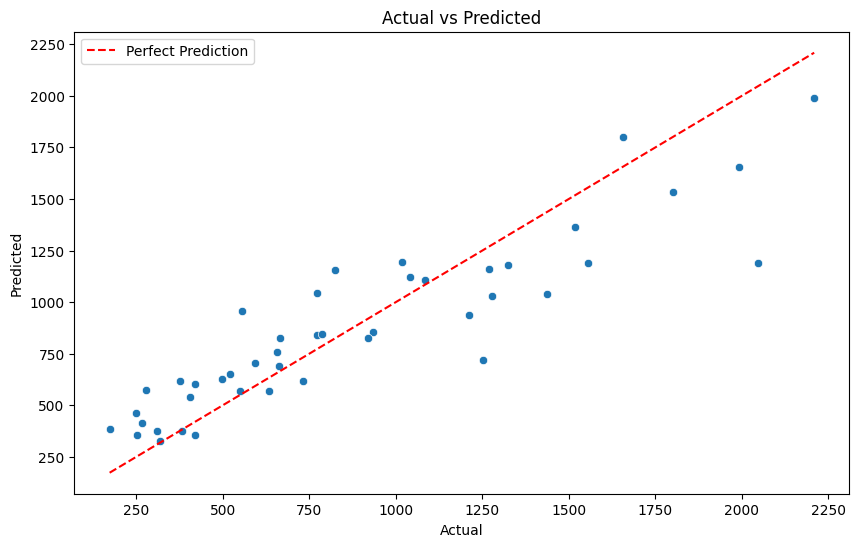

In [111]:
plot_actual_vs_predicted(y_test, test_pred_rf_new_tune)

# LGBM

In [112]:
model = LGBMRegressor()
model_lm_new, train_pred_lm_new, test_pred_lm_new, best_params_lm_new = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid={})

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 13
[LightGBM] [Info] Start training from score 781.210993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

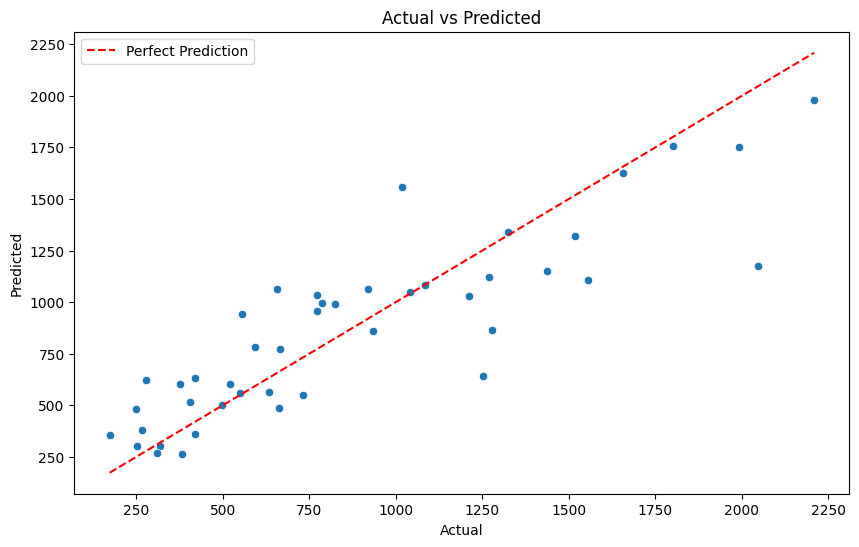

In [113]:
plot_actual_vs_predicted(y_test, test_pred_lm_new)

In [114]:
param_grid_lm_new_tune = {
    'n_estimators': [100, 200],            # Jumlah boosting iterations, rentang optimal dan cepat
    'learning_rate': [0.05, 0.1],          # Fokus pada kecepatan pembelajaran sedang
    'max_depth': [5, 10],                  # Pilihan kedalaman rendah-sedang
    'num_leaves': [31, 50],                # Jumlah maksimum leaf nodes optimal
    'min_child_samples': [10, 20],         # Minimum sample pada leaf node untuk stabilisasi
    'subsample': [0.8, 1.0],               # Subsampling untuk generalisasi lebih baik
    'colsample_bytree': [0.8, 1.0],        # Subsampling kolom untuk generalisasi
    'reg_alpha': [0.0, 0.1],               # L1 regularisasi sederhana
    'reg_lambda': [0.1, 0.5]               # L2 regularisasi untuk balancing kompleksitas
}

model = LGBMRegressor()
model_lm_new_tune, train_pred_lm_new_tune, test_pred_lm_new_tune, best_params_lm_new_tune = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid=param_grid_lm_new_tune)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 13
[LightGBM] [Info] Start training from score 781.210993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

d:\Meli\Repositori local\Chemical-Estimation\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


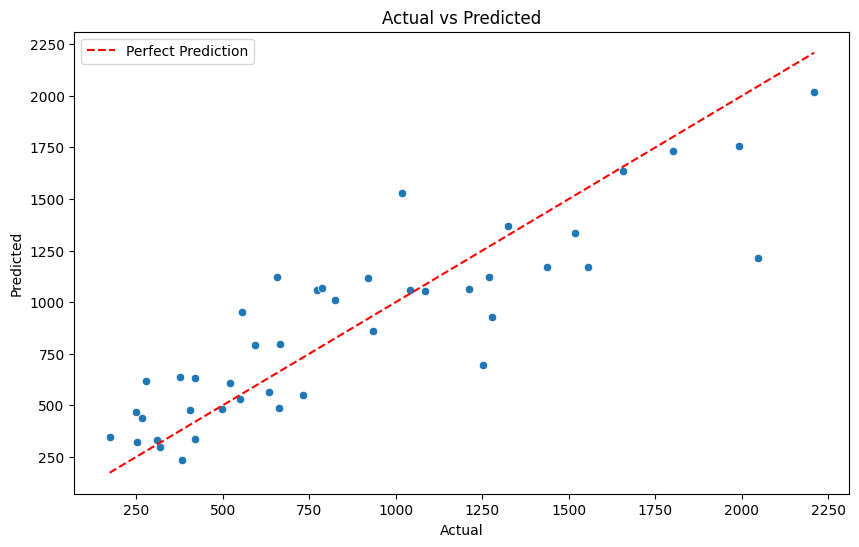

In [115]:
plot_actual_vs_predicted(y_test, test_pred_lm_new_tune)

# Stuck

In [116]:
base_model = [
    ('rf', RandomForestRegressor(**best_params_rf_new_tune, random_state=72)),
    ('xgb', XGBRegressor(**best_params_xg_new_tune)),
    ('lgbm', LGBMRegressor())
    #('ridge', Ridge(alpha=10, fit_intercept=False, max_iter=5000, solver='saga')),
    #('svr', SVR(C=100, coef0=0.0, degree=2, epsilon=1.0, gamma='scale',kernel='linear' )),
    #('lasso', Lasso()),
    # ('lr', LinearRegression())
    # ('knn', KNeighborsRegressor(n_neighbors=5)).
    # ('dt', DecisionTreeRegressor())
]

meta_model = SVR(kernel='linear') 

model = StackingRegressor(estimators=base_model, final_estimator=meta_model, cv=5)
model_stc_new, train_pred_stc_new, test_pred_stc_new, best_params_stc_new = create_model(model, X_train_new, y_train, X_test_new, y_test, param_grid={})

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 13
[LightGBM] [Info] Start training from score 781.210993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

# Save Model

In [117]:
import pickle

def save_model(file_name, model):
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

In [118]:
preprocessor

ColumnTransformer(transformers=[('numeric_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['DAY_RUN', 'RR', 'AVG_T_RETURN', 'AVG_FRC',
                                  'AVG_CHLORIDE']),
                                ('conduct_category',
                                 Pipeline(steps=[('categorize',
                                                  CategoriConduct())]),
                                 ['CONDUCT LIMIT']),
                                ('label_encode',
                                 Pipeline(steps=[('label_encode',
                                                  LabelEncode())]),
                                 ['BACTERIA_STATUS']),
                                ('ohe',
                                 Pipeline(steps=[('ohe', OneHotEncoder())]),
                                 ['FUNCTION']),
                                ('material_binarizer',
                                 Pipeline(steps=[('binarizer',
                                                  MaterialEncoder(column_name='MATERIAL'))]),
                                 ['MATERIAL'])])

In [ ]:
# from joblib import dump

# # Simpan preprocessor
# dump(preprocessor, 'preprocessor.joblib')

PicklingError: Can't pickle <class '__main__.CategoriConduct'>: it's not the same object as __main__.CategoriConduct

In [125]:
# Stucking model 
save_model('model_stuck.pkl', model_stc)

# preprocessor 
save_model('preprocessor.pkl', preprocessor)

In [37]:
# # LR
# save_model('model_lr.pkl', model_lr)

# # Lasso 
# save_model('model_lasso.pkl', model_lasso_tune)

# # Ridge
# save_model('model_ridge.pkl', model_rid_tune)

# # RF
# save_model('model_rf.pkl', model_rf)

# Data Load

In [ ]:
class DataLoad():
    def __init__(self, file):
        self.file = file

    def load(self):
        data = pd.read_csv(self.file)

    def split(self):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)
        return